In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tqdm import trange, tqdm

from src.data.ucmerced_dataset import UcMercedDataset
from src.settings import DATA_DIRECTORY

In [3]:
dataset = UcMercedDataset(DATA_DIRECTORY)

In [4]:
x = np.empty(shape=(dataset.__len__(), 256, 256, 3))
y = np.empty(shape=(dataset.__len__(), ), dtype=np.int)

for idx in trange(dataset.__len__()):
    item = dataset.__getitem__(idx)

    x[idx] = item['a']
    y[idx] = item['a_y']

100%|██████████| 2056/2056 [00:11<00:00, 175.54it/s]


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

In [6]:
sift = cv2.SIFT_create()

In [57]:
def get_descriptors(images):
    desc = []

    for img in tqdm(images, desc="Calculating SIFT descriptors"):
        cv_img = img_as_ubyte(img)
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)
        _, d = sift.detectAndCompute(cv_img, None)
        if d is not None:
            desc.append(d)

    return desc

In [19]:
stacked_train_descriptors = np.vstack(get_descriptors(x_train))

In [20]:
CLUSTERS = 1000
SAMPLES_COUNT = 100000

In [21]:
%%time

k_means = KMeans(n_clusters=CLUSTERS)

k_means.fit(stacked_train_descriptors[np.random.choice(
    stacked_train_descriptors.shape[0],
    SAMPLES_COUNT,
    replace=False
)])

CPU times: user 1h 5min 50s, sys: 31min 33s, total: 1h 37min 23s
Wall time: 30min 45s


KMeans(n_clusters=1000)

In [59]:
def encode_as_bovw(x: np.ndarray, trained_kmeans: KMeans) -> np.ndarray:
    descriptors = get_descriptors(x)

    res = np.empty(shape=(x.shape[0], trained_kmeans.n_clusters))

    for idx, desc in tqdm(
            enumerate(descriptors),
            total=len(descriptors),
            desc="Encoding as BOVW"):
        words = trained_kmeans.predict(desc)
        bovw, _ = np.histogram(words, bins=range(trained_kmeans.n_clusters + 1))
        res[idx] = bovw / desc.shape[0]

    return res

In [60]:
x_test_encoded = encode_as_bovw(x_test, k_means)

Encoding as BOVW: 100%|██████████| 1643/1643 [01:04<00:00, 25.33it/s]


In [63]:
n_neighbours = NearestNeighbors()
n_neighbours.fit(x_test_encoded)

NearestNeighbors()

In [78]:
QUERY_IMAGE_IDX = 0

In [79]:
query_image = x_test_encoded[QUERY_IMAGE_IDX].reshape(1, -1)
_, query_result_idx = n_neighbours.kneighbors(query_image, n_neighbors=5)

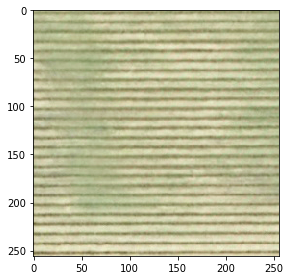

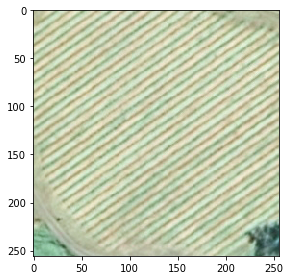

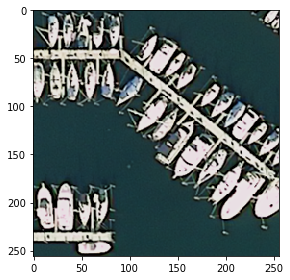

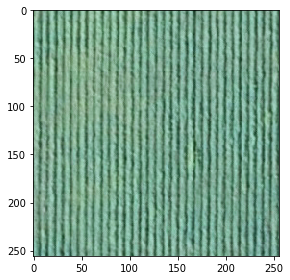

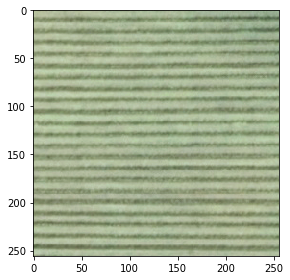

In [80]:
for idx in query_result_idx.squeeze():
    io.imshow(x_test[idx])
    plt.show()
